In [1]:
## import statements for the regression pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns


# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

# import scaling methods
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split

# import modeling methods
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from scipy import stats

# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

import acquire as a
import prepare as p
import model as m

### Executive Summary

The purpose of this notebook is create a regression model that predicts the price of used bmw vehicles in a dataset from kaggle.com

link: https://www.kaggle.com/mysarahmadbhat/bmw-used-car-listing

The best drivers in predicting the price of the bmws were
 - year
 - mileage
 - tax
 - mpg
 - engineSize
 - is_diesel
 - is_hybrid
 - is_manual
 - is_semiauto
 - is_automatic

In conclusion, the end result and real world application is provide a baseline for bmw dealerships to work together to create equal pricing in their vehicles for a more satisfied customer base.

### Acquire 

In [2]:
df = a.get_bmw_data() ## using our acquire functionn

In [3]:
df.head() ## previewing our data

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [4]:
stats_df = a.acquire_stats(df) ## using our custom function to output numerical statistics
## for the player stats dataframe

stats_df.head() ## previewing our numerical statistics dataframe

,count,mean,std,min,25%,50%,75%,max,range
year,10781.0,2017.078935,2.349038,1996.0,2016.0,2017.0,2019.0,2020.0,24.0
price,10781.0,22733.408867,11415.528189,1200.0,14950.0,20462.0,27940.0,123456.0,122256.0
mileage,10781.0,25496.986550,25143.192559,1.0,5529.0,18347.0,38206.0,214000.0,213999.0
tax,10781.0,131.702068,61.510755,0.0,135.0,145.0,145.0,580.0,580.0
mpg,10781.0,56.399035,31.336958,5.5,45.6,53.3,62.8,470.8,465.3


In [5]:
a.summarize_df(df) ## using our custom script function to look at data types and nulls

Info on Columns and Datatypes:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB
None
------------------------------------------------

Value Counts for fuelType:

Diesel      7027
Petrol      3417
Hybrid       298
Other         36
Electric       3
Name: fuelType, dtype: int64
--------------------
Value Counts for transmission:

Semi-Auto    4666
Automatic    3588
Manual       2527
Name: transmission,

Distribution of year



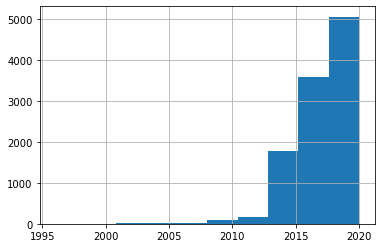

--------------------
Distribution of price



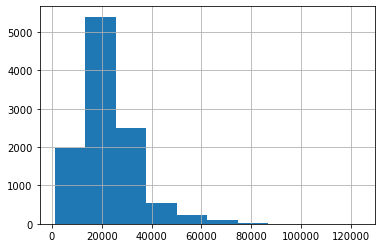

--------------------
Distribution of mileage



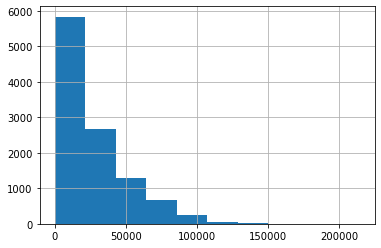

--------------------
Distribution of tax



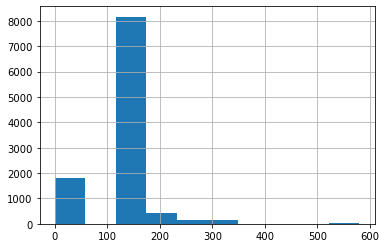

--------------------
Distribution of mpg



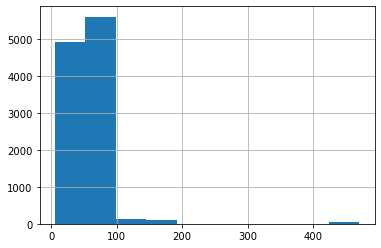

--------------------
Distribution of engineSize



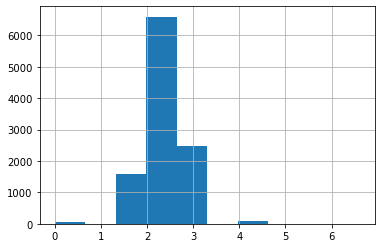

--------------------


In [6]:
## using our custom script funciton to look at distributions
a.univariate_distributions(df)

### Acquire Takeaways
When looking at the distribution of variables there are normal distributions in engineSize and price while the others are skewed to the right and left.

When looking at the datatypes there are correct datatypes for our numerical and object variables. It also looks like there are several categorical options that can be split up and used to create more features for modeling.

### Prepare

In [7]:
## first we will use our strip string function so whitespace doesn't interfere with our 
## modeling or data exploration

df = p.strip_strings(df) 

In [8]:
## second we will use our drop duplicates and create features function to create all of
## our features and that we will explore prior to modeling

df = p.drop_dups_create_features(df)

In [9]:
df.head() ## previewing our function made changes

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,is_diesel,is_electric,is_hybrid,is_manual,is_semiauto,is_automatic
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,1,0,0,0,0,1
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,0,0,0,0,0,1
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,1,0,0,0,0,1
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,1,0,0,0,0,1
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,1,0,0,0,0,1


In [10]:
## quality assurance check function
p.double_checker(df)

Diesel      6988
Petrol      3340
Hybrid       297
Other         36
Electric       3
Name: fuelType, dtype: int64
--------------------

Value Counts for is_diesel:

1    6988
0    3676
Name: is_diesel, dtype: int64
--------------------
Value Counts for is_electric:

0    10661
1        3
Name: is_electric, dtype: int64
--------------------
Value Counts for is_hybrid:

0    10367
1      297
Name: is_hybrid, dtype: int64
--------------------
Semi-Auto    4637
Automatic    3542
Manual       2485
Name: transmission, dtype: int64
--------------------

Value Counts for is_manual:

0    8179
1    2485
Name: is_manual, dtype: int64
--------------------
Value Counts for is_semiauto:

0    6027
1    4637
Name: is_semiauto, dtype: int64
--------------------
Value Counts for is_automatic:

0    7122
1    3542
Name: is_automatic, dtype: int64
--------------------


Now We can see that all value counts match up and are correct for the one hot encoded columns.

#### Train, Validate, Test Split

In [11]:
## using our data split function to split into train validate, & test dataframes

train, validate, test = p.split_data(df)

Making Sure Our Shapes Look Good
Train: (5971, 15), Validate: (2560, 15), Test: (2133, 15)


In [12]:
train.head() ## preveiwing train

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,is_diesel,is_electric,is_hybrid,is_manual,is_semiauto,is_automatic
9374,1 Series,2016,17499,Automatic,26855,Petrol,235,37.7,3.0,0,0,0,0,0,1
6316,3 Series,2018,21991,Semi-Auto,15027,Diesel,150,64.2,2.0,1,0,0,0,1,0
5725,X1,2017,23990,Semi-Auto,1061,Petrol,165,44.8,2.0,0,0,0,0,1,0
546,X1,2016,19498,Semi-Auto,20153,Diesel,145,55.4,2.0,1,0,0,0,1,0
9909,1 Series,2012,6990,Manual,58000,Diesel,30,62.8,2.0,1,0,0,1,0,0


In [13]:
validate.head() ## previewing validate

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,is_diesel,is_electric,is_hybrid,is_manual,is_semiauto,is_automatic
8146,1 Series,2013,7440,Manual,75323,Petrol,145,49.6,1.6,0,0,0,1,0,0
6398,2 Series,2019,22991,Semi-Auto,7755,Diesel,150,65.7,2.0,1,0,0,0,1,0
197,X1,2016,16698,Semi-Auto,37272,Petrol,160,44.8,2.0,0,0,0,0,1,0
5545,1 Series,2017,20081,Semi-Auto,32000,Petrol,200,39.8,3.0,0,0,0,0,1,0
1360,4 Series,2019,30766,Automatic,123,Diesel,145,60.1,2.0,1,0,0,0,0,1


In [14]:
test.head() ## previewing test

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,is_diesel,is_electric,is_hybrid,is_manual,is_semiauto,is_automatic
7544,2 Series,2015,14250,Manual,11000,Petrol,125,50.4,1.5,0,0,0,1,0,0
3881,X1,2020,28940,Semi-Auto,1550,Diesel,145,53.3,2.0,1,0,0,0,1,0
1135,1 Series,2017,20998,Semi-Auto,24999,Petrol,200,39.8,3.0,0,0,0,0,1,0
1804,5 Series,2018,28992,Automatic,19625,Diesel,145,53.3,3.0,1,0,0,0,0,1
1064,3 Series,2017,18985,Semi-Auto,28173,Hybrid,0,134.5,2.0,0,0,1,0,1,0


### Prepare Takeaways

We have made several one hot encoded columns to explore for to use as potential modeling features from our categorical columns.

Columns made:
 - is_diesel
 - is_electric
 - is_hybrid
 - is_manual
 - is_semiauto
 - is_automatic
 
The train, validate, test splits look consistent with the correct dataframe shapes and I am ready to explore the train dataframe for to look for features that drive the price of the BMW cars for modeling.

Nothing was done to remove outliers in this dataset and there weren't any null values to remove.

### Explore

#### Heatmap With Target Variable

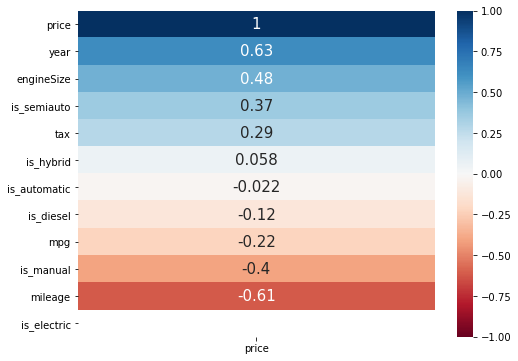

In [15]:
## making a heap map to look at correlations with is_fraud for the train data set
## helping me choose which features to use in my model

plt.figure(figsize = (8,6))  
sns.heatmap(train.corr()[['price']].sort_values(by='price', ascending = False), 
            cmap = 'RdBu', vmax = 1, vmin = -1, center = 0, annot = True, annot_kws={"size": 15} )
plt.show()

#### Correlations Between All Variables

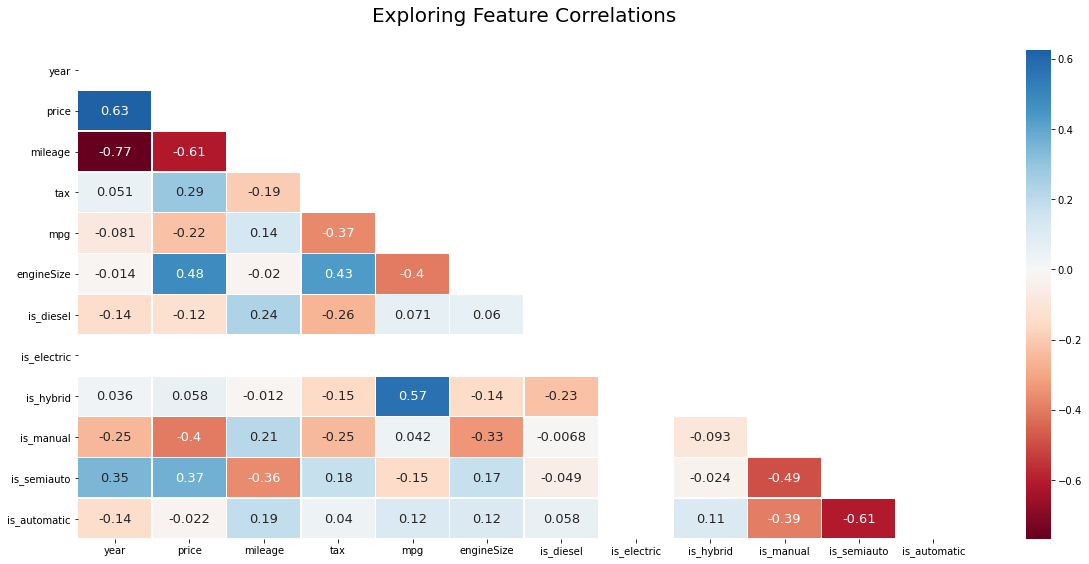

In [16]:
## defining correlation variable for heatmap
corr = train.corr()

## creating a heatmap of the correlation between all columns in our dataframe

plt.figure(figsize=(20,9))
mask = np.zeros_like(corr)  ## <-- creating a mask
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, annot=True, linewidths=.5, cmap='RdBu',
            annot_kws={"size": 13}, mask=mask)
plt.title('Exploring Feature Correlations\n', {'fontsize': 20})
plt.show()

#### Pairplot

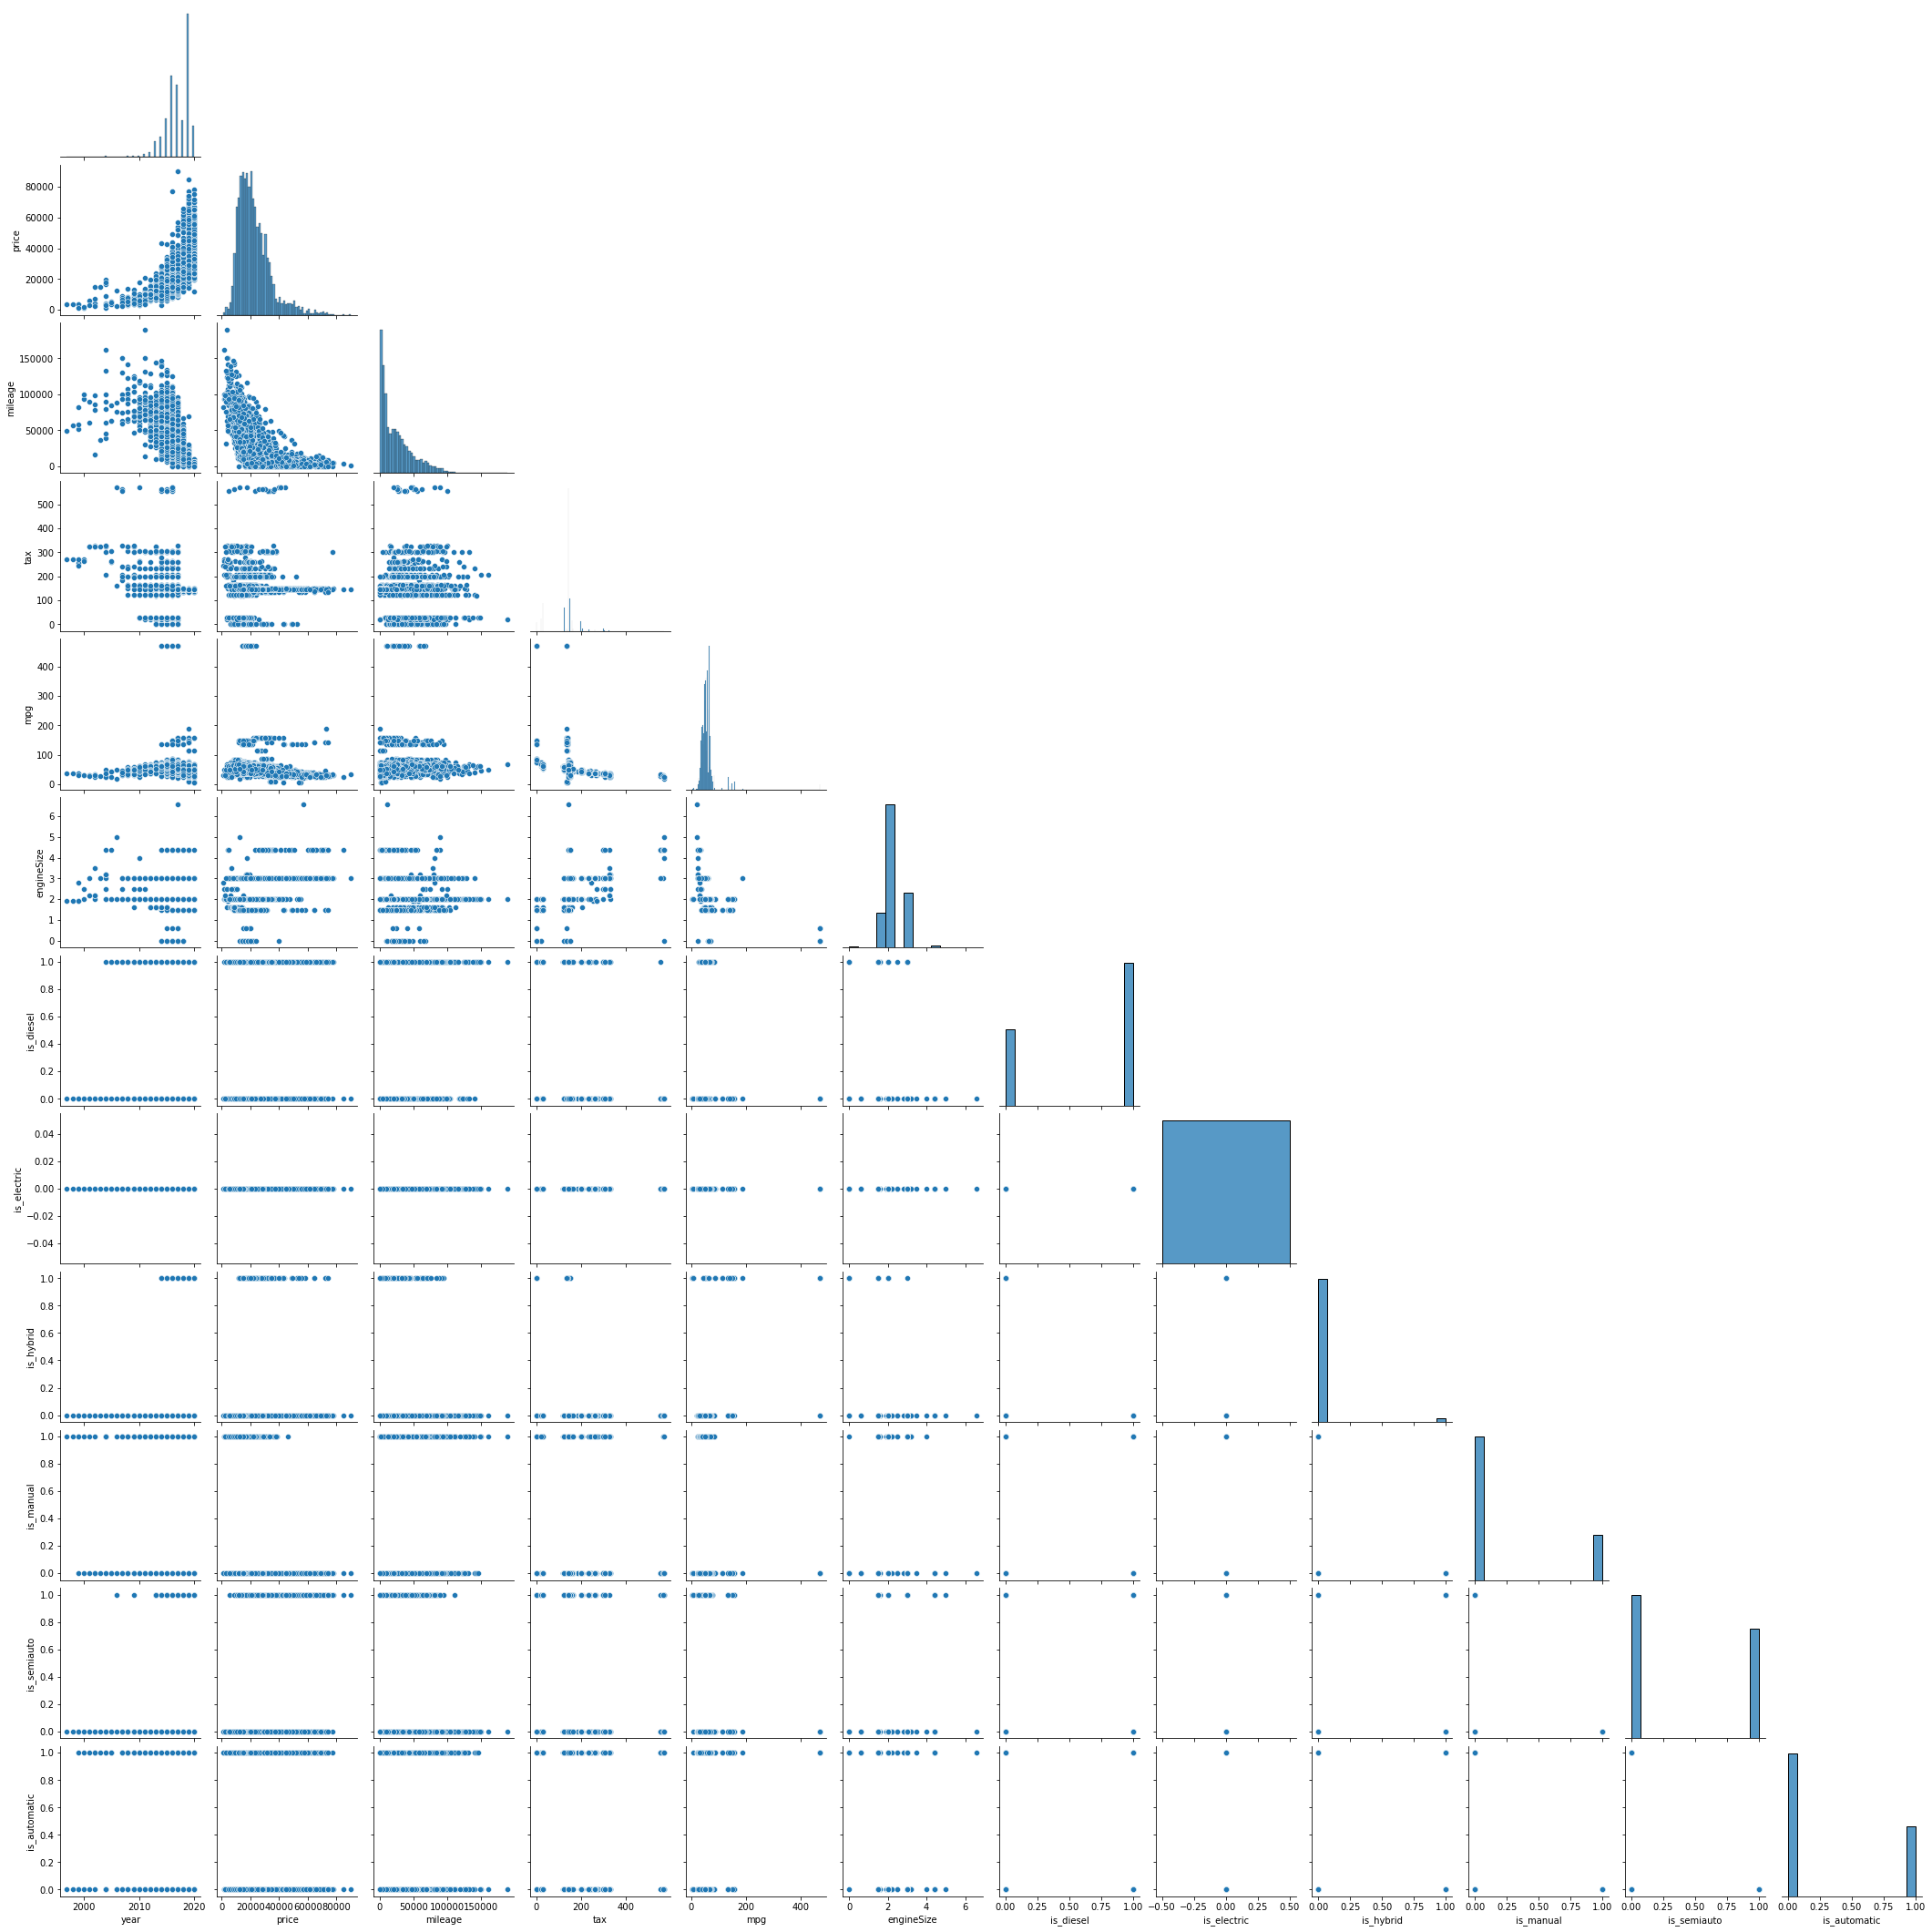

In [17]:
sns.pairplot(data = train, corner = True) ## looking at our variable relationships
plt.show()

#### Bar Graphs

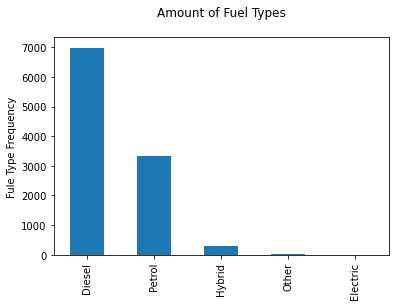

In [18]:
df['fuelType'].value_counts().plot.bar()
plt.ylabel('Fule Type Frequency')
plt.title('Amount of Fuel Types\n')
plt.show()

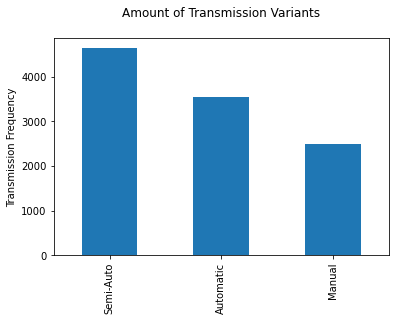

In [19]:
df['transmission'].value_counts().plot.bar()
plt.ylabel('Transmission Frequency')
plt.title('Amount of Transmission Variants\n')
plt.show()

#### Explore: Statistics

In [20]:
alpha = 0.05 ## <-- Determining alpha value

Correlation Tests of 
 - year
 - engineSize
 - is_manual
 - mileage

To target variable: price

Standard Hypothesis for correlation test of all variables

$H_0$ : There is no relationship between these variables

$H_a$ : There is evidence to suggest there is a realtionhip between these two variables

In [51]:
## performing correlation test on year and price because the heat map showed
## a good correlation value.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.year, train.price)
corr, p

(0.6262016360399899, 0.0)

With a correlation of 0.63 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a significant realtionship between the year a vehicle was manufactured and the price of the vehicle, thus accepting the alternate hypothesis.

In [52]:
## performing correlation test on engineSize and price because the heat map showed
## a good correlation value.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.engineSize, train.price)
corr, p

(0.48002165240809064, 0.0)

With a correlation of 0.48 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a significant realtionship between the engine size of a vehicle was manufactured and the price of the vehicle, thus accepting the alternate hypothesis.

In [53]:
## performing correlation test on is_manual and price because the heat map showed
## a good correlation value.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.is_manual, train.price)
corr, p

(-0.40162811931023357, 2.5459071111204204e-230)

With a correlation of -0.40 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a significant realtionship between whether a vehicle is manual or automatic and the price of the vehicle, thus accepting the alternate hypothesis.

In [55]:
## performing correlation test on year and price because the heat map showed
## a good correlation value.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.mileage, train.price)
corr, p

(-0.6118224962438434, 0.0)

With a correlation of -0.61 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a significant realtionship between the amount of miles a vehicle has been driven and the price of the vehicle, thus accepting the alternate hypothesis.

We have some strong correlations between our target variable: price of a used bmw and its mileage, engineSize, year manufactured, and whether or not it is manual or automatic transmission. These values were pearson r correlation tested and these correlations proved to be significant and not random.

Given how strong these correlations are with the target variable price we are going to use recursive feature elimination to see if these variables appear in the features list and use them in the modeling phase.

### Modeling 

#### Splitting into X and Y's For Modeling

In [21]:
## Setting up X and y's by dropping target variable from X's and setting them to y

## also dropping unneccessary columns for predicting target variable


X_train, y_train = train.drop(columns = ['price', 'model', 'fuelType', 'transmission']), train.price
X_validate, y_validate = validate.drop(columns = ['price', 'model', 'fuelType', 'transmission']), validate.price
X_test, y_test = test.drop(columns = ['price', 'model', 'fuelType', 'transmission']), test.price

In [22]:
X_train.head() ## previewing the X train

,year,mileage,tax,mpg,engineSize,is_diesel,is_electric,is_hybrid,is_manual,is_semiauto,is_automatic
9374,2016,26855,235,37.7,3.0,0,0,0,0,0,1
6316,2018,15027,150,64.2,2.0,1,0,0,0,1,0
5725,2017,1061,165,44.8,2.0,0,0,0,0,1,0
546,2016,20153,145,55.4,2.0,1,0,0,0,1,0
9909,2012,58000,30,62.8,2.0,1,0,0,1,0,0


In [23]:
y_train.head() ## previewing our y_train array

9374    17499
6316    21991
5725    23990
546     19498
9909     6990
Name: price, dtype: int64

In [24]:
## Turning all my y's into dataframe

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [25]:
y_train.head() ## previewing our y_train dataframe

,price
9374,17499
6316,21991
5725,23990
546,19498
9909,6990


#### Recursive Feature Elimination

In [26]:
# call rfe function from explore script
features_to_use, feature_rankings = m.select_rfe(X_train, y_train, 10, return_rankings=True)

In [27]:
features_to_use ## looking at our list of features to use in the model

['year',
 'mileage',
 'tax',
 'mpg',
 'engineSize',
 'is_diesel',
 'is_hybrid',
 'is_manual',
 'is_semiauto',
 'is_automatic']

In [28]:
features = [
 'year',
 'mileage',
 'tax',
 'mpg',
 'engineSize',
 'is_diesel',
 'is_hybrid',
 'is_manual',
 'is_semiauto',
 'is_automatic'   
]

#### Establishing Mean & Median Baseline

In [29]:
## rating mean
price_pred_mean = y_train['price'].mean()
y_train['price_pred_mean'] = price_pred_mean
y_validate['price_pred_mean'] = price_pred_mean

## rating median
price_pred_median = y_train['price'].median()
y_train['price_pred_median'] = price_pred_median
y_validate['price_pred_median'] = price_pred_median

## RMSE of rating mean train and validate scores
rmse_train = mean_squared_error(y_train.price, y_train.price_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.price, y_validate.price_pred_mean)**(1/2)

print('Baseline')
print('-----------------------------')
print('RMSE using Mean\nTrain/In-Sample: ', round(rmse_train, 4), 
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 4))
print('-----------------------------')

## RMSE of rating_pred_median train and validate scores
rmse_train = mean_squared_error(y_train.price, y_train.price_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.price, y_validate.price_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

## R squared score for baseline
print('-----------------------------')
r2_baseline = r2_score(y_validate.price, y_validate.price_pred_mean)
print(f'The R squared score for the baseline is {r2_baseline}')

Baseline
-----------------------------
RMSE using Mean
Train/In-Sample:  11380.6354 
Validate/Out-of-Sample:  11537.3066
-----------------------------
RMSE using Median
Train/In-Sample:  11634.3044 
Validate/Out-of-Sample:  11770.7427
-----------------------------
The R squared score for the baseline is -5.076622499866623e-05


Choosing the mean as our baseline because it has a lower RMSE score for the train and validate samples

In [30]:
# create df to hold metrics
metrics_df = pd.DataFrame()

In [31]:
## adding our mean baseline to our metric dataframe
metrics_df = m.get_metrics(metrics_df, 'mean_baseline',rmse_validate,explained_variance_score(y_validate.price, y_validate.price_pred_median))

In [32]:
##previewing our metrics_df
metrics_df

,model,r^2_outofsample,rmse_outofsample
0,mean_baseline,0.0,11770.742671


##### OLS: Linear Regression

In [33]:
# create the model object

lm = LinearRegression(fit_intercept=True)

# fit the model to our training data. We must specify the column in y_train, since we have converted it to a dataframe from a series! 

# fit the thing using only the features we selected
lm.fit(X_train[features], y_train.price)

# predict train

y_train['price_pred_lm'] = lm.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.price, y_train.price_pred_lm) ** (1/2)

# predict validate
y_validate['price_pred_lm'] = lm.predict(X_validate[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.price, y_validate.price_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for OLS: {r2_score(y_validate.price, y_validate.price_pred_lm)}')

RMSE for OLS using LinearRegression
Training/In-Sample:  6425.741506738226 
Validation/Out-of-Sample:  7003.348286799939
------------------------------------------------
R squared score for OLS: 0.6315109148427899


In [34]:
## adding our OLS scores to our metric dataframe
metrics_df = m.get_metrics(metrics_df, 'OLS_Linear_Regression',rmse_validate,explained_variance_score(y_validate.price, y_validate.price_pred_lm))

In [35]:
metrics_df ## previewing metrics df

,model,r^2_outofsample,rmse_outofsample
0,mean_baseline,0.00000,11770.742671
1,OLS_Linear_Regression,0.63153,7003.348287


##### Lasso Lars

In [36]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data using only selected features. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series
lars.fit(X_train[features], y_train.price)

# predict train
y_train['price_pred_lars'] = lars.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.price, y_train.price_pred_lars) ** 0.5

# predict validate
y_validate['price_pred_lars'] = lars.predict(X_validate[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.price, y_validate.price_pred_lars) ** 0.5

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for OLS: {r2_score(y_validate.price, y_validate.price_pred_lars)}')

RMSE for Lasso + Lars
Training/In-Sample:  6428.416130994764 
Validation/Out-of-Sample:  6993.942334075342
------------------------------------------------
R squared score for OLS: 0.6325000598194337


In [37]:
## adding our Lasso Lars scores to our metric dataframe
metrics_df = m.get_metrics(metrics_df, 'Lasso_Lars',rmse_validate,explained_variance_score(y_validate.price, y_validate.price_pred_lars))

In [38]:
metrics_df ## previewing metrics df

,model,r^2_outofsample,rmse_outofsample
0,mean_baseline,0.000000,11770.742671
1,OLS_Linear_Regression,0.631530,7003.348287
2,Lasso_Lars,0.632521,6993.942334


##### Tweedie Regressor 

In [39]:
# create the model object
glm = TweedieRegressor(power=0, alpha=1)

# fit the model to our training data using only selected features. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series
glm.fit(X_train[features], y_train.price)

# predict train
y_train['price_pred_glm'] = glm.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.price, y_train.price_pred_glm) ** 0.5

# predict validate
y_validate['price_pred_glm'] = glm.predict(X_validate[features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.price, y_validate.price_pred_glm) ** 0.5

print("RMSE for Tweedie Regressor\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for Tweedie Regressor: {r2_score(y_validate.price, y_validate.price_pred_glm)}')

RMSE for Tweedie Regressor
Training/In-Sample:  8103.085935301574 
Validation/Out-of-Sample:  8522.971967556174
------------------------------------------------
R squared score for Tweedie Regressor: 0.45424804711353517


In [40]:
## adding our Tweedie Regressor scores to our metric dataframe
metrics_df = m.get_metrics(metrics_df, 'Tweedie Regressor',rmse_validate,explained_variance_score(y_validate.price, y_validate.price_pred_glm))

In [41]:
metrics_df

,model,r^2_outofsample,rmse_outofsample
0,mean_baseline,0.000000,11770.742671
1,OLS_Linear_Regression,0.631530,7003.348287
2,Lasso_Lars,0.632521,6993.942334
3,Tweedie Regressor,0.454271,8522.971968


##### 2nd Degree Polynomial Features

In [42]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = pf.fit_transform(X_train[features])

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate[features])
X_test_degree2 = pf.transform(X_test[features])

In [43]:
#create the model object

pm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

# fit the thing

pm.fit(X_train_degree2, y_train.price)

# predict train

y_train['price_pred_pm'] = pm.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.price, y_train.price_pred_pm) ** (1/2)

# predict validate
y_validate['price_pred_pm'] = pm.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.price, y_validate.price_pred_pm) ** (1/2)

print("RMSE for Polynomial Regression With 2 Degrees\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for Polynomial Regression With 2 Degrees: {r2_score(y_validate.price, y_validate.price_pred_pm)}')

RMSE for Polynomial Regression With 2 Degrees
Training/In-Sample:  4649.405614189075 
Validation/Out-of-Sample:  6355.770393187436
------------------------------------------------
R squared score for Polynomial Regression With 2 Degrees: 0.6965063717693085


In [44]:
## adding our Tweedie Regressor scores to our metric dataframe
metrics_df = m.get_metrics(metrics_df, 'Polynomial Regression 2 Degrees',rmse_validate,explained_variance_score(y_validate.price, y_validate.price_pred_pm))

In [45]:
metrics_df ## previewing our metric scores

,model,r^2_outofsample,rmse_outofsample
0,mean_baseline,0.000000,11770.742671
1,OLS_Linear_Regression,0.631530,7003.348287
2,Lasso_Lars,0.632521,6993.942334
3,Tweedie Regressor,0.454271,8522.971968
4,Polynomial Regression 2 Degrees,0.696528,6355.770393


#### Final Model: Testing 2 Degree Polynomial Regression

In [46]:
# predict on test
y_test['price_pred_pm'] = pm.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.price, y_test.price_pred_pm) ** 0.5
print("RMSE for Model using Polynomial Regression: 2 Degrees\nOut-of-Sample Performance: ", rmse_test)
print('------------------------------------------------')
print(f'R squared score for Polynomial Regression With 2 Degrees: {r2_score(y_test.price, y_test.price_pred_pm)}')

RMSE for Model using Polynomial Regression: 2 Degrees
Out-of-Sample Performance:  5121.329793774141
------------------------------------------------
R squared score for Polynomial Regression With 2 Degrees: 0.8003074913509698


In [47]:
# add test model to df
metrics_df = m.get_metrics(metrics_df, 'Test',rmse_test,explained_variance_score(y_test.price, y_test.price_pred_pm))

In [48]:
metrics_df ## previewing scores

,model,r^2_outofsample,rmse_outofsample
0,mean_baseline,0.000000,11770.742671
1,OLS_Linear_Regression,0.631530,7003.348287
2,Lasso_Lars,0.632521,6993.942334
3,Tweedie Regressor,0.454271,8522.971968
4,Polynomial Regression 2 Degrees,0.696528,6355.770393
5,Test,0.800437,5121.329794


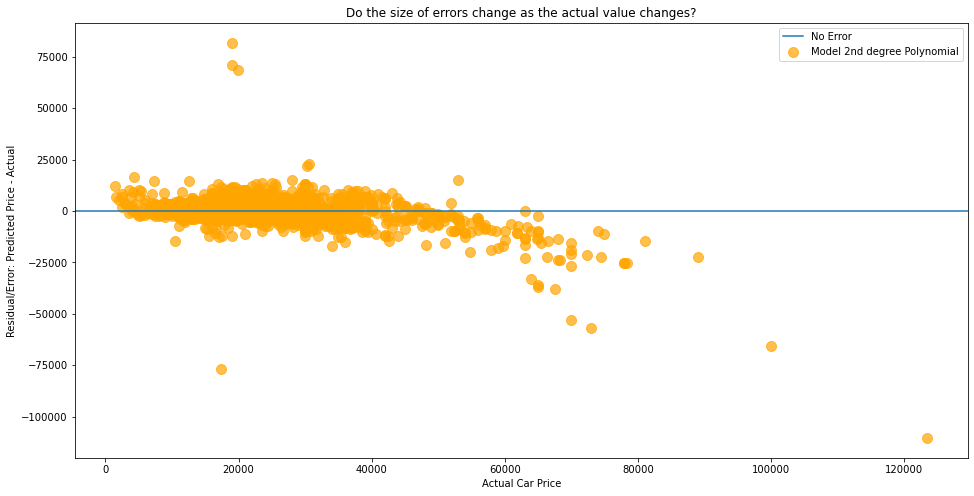

In [49]:
# plot the residuals for the best performing model

plt.figure(figsize=(16,8))
plt.axhline(label="No Error")

plt.scatter(y_validate.price, y_validate.price_pred_pm - y_validate.price, 
            alpha=.7, color="orange", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Car Price")
plt.ylabel("Residual/Error: Predicted Price - Actual")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()

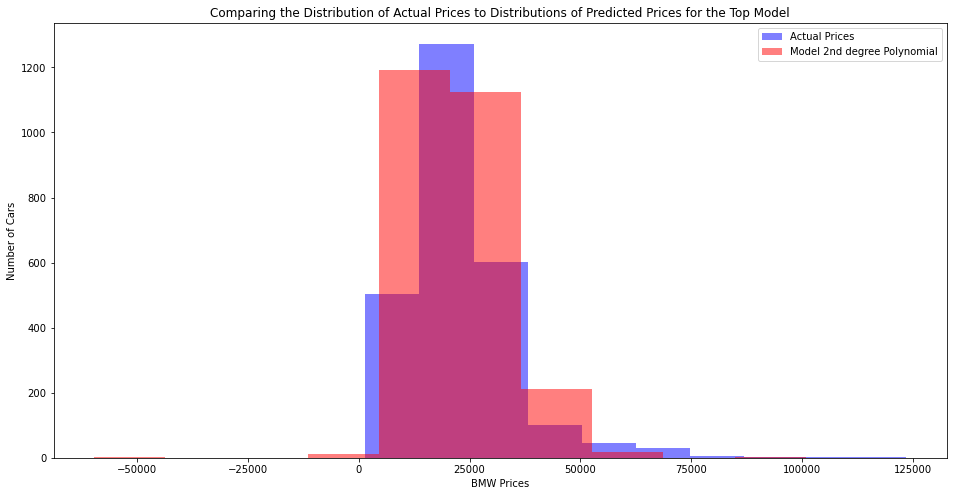

In [50]:
# plot to visualize actual vs predicted values
plt.figure(figsize=(16,8))
plt.hist(y_validate.price, color='blue', alpha=.5, label="Actual Prices")
plt.hist(y_validate.price_pred_pm, color='red', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("BMW Prices")
plt.ylabel("Number of Cars")
plt.title("Comparing the Distribution of Actual Prices to Distributions of Predicted Prices for the Top Model")
plt.legend()
plt.show()

### Final Takeaways & Modeling Takeaways

Recursive feature elimination was used to determine the best features for regression modeling. The features used in modeling were:
 - year
 - mileage
 - tax
 - mpg
 - engineSize
 - is_diesel
 - is_hybrid
 - is_manual
 - is_semiauto
 - is_automatic

The features that had the strongest correlation the price of a used bmw were mileage, engine size, year manufactured, and whether or not the vehicle was automatic or manual.

In the regression modeling the best performing model in train and validate was the polynomial regression model using 2 degrees.

Therfore it was used on the out-of-sample dataframe (test dataframe) and came our with the following scores:

Polynomial Regression: Using 2 Degrees
 - RMSE: 5121.33
 - R